In [79]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import yfinance as yf
from pandas_datareader import data as pdr

In [80]:
#read data
sets = pd.read_csv('sets.csv', sep=";")
themes = pd.read_csv('themes.csv')

In [81]:
#merge data into one dataframe
sets_themes = pd.merge(sets, themes, how='left', left_on='theme_id', right_on='id', suffixes=('_sets', '_themes'))
sets_themes = sets_themes.drop(['id', 'parent_id'], axis='columns')

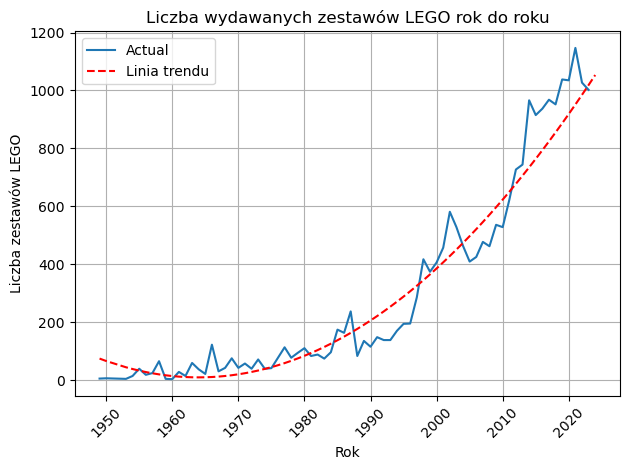

In [82]:
# Number of sets released per year
sets_by_year = sets_themes.groupby("year").size().reset_index(name="set_num")

# Plot actual data
plt.plot(sets_by_year["year"][:-1], sets_by_year["set_num"][:-1], label="Actual")

# Add trend line
trendline = np.polyfit(sets_by_year["year"], sets_by_year["set_num"], 2)
p = np.poly1d(trendline)
plt.plot(sets_by_year["year"], p(sets_by_year["year"]), "r--", label="Linia trendu")

# Configure plot
plt.legend()
plt.title('Liczba wydawanych zestawów LEGO rok do roku')
plt.xlabel("Rok")
plt.ylabel("Liczba zestawów LEGO")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

In [83]:
#Sets released per year (table)
sets_by_year_table = sets_themes.groupby("year").count()
sets_by_year_table["set_num"][:-1]

year
1949       5
1950       6
1953       4
1954      14
1955      39
        ... 
2019    1038
2020    1035
2021    1147
2022    1027
2023    1002
Name: set_num, Length: 73, dtype: int64

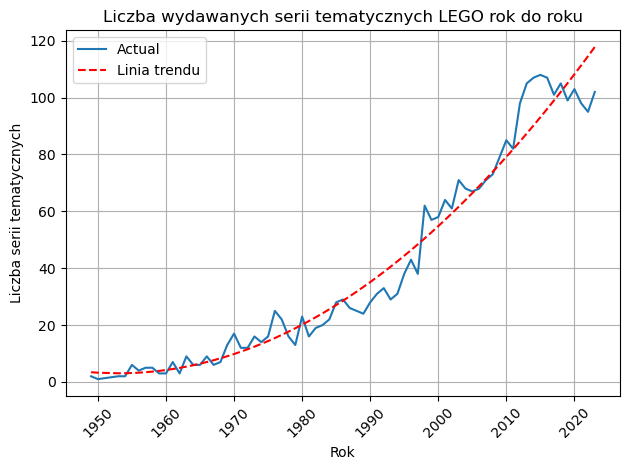

In [84]:
# Number of themes by year
themes_by_year = sets_themes.groupby("year")["theme_id"].nunique().reset_index(name="nr_themes")

# Calculate the trend line
z = np.polyfit(themes_by_year["year"].values[:-1], themes_by_year["nr_themes"].values[:-1], 2)
p = np.poly1d(z)

# Plot the data points and the trend line
plt.plot(themes_by_year["year"].values[:-1], themes_by_year["nr_themes"].values[:-1], label="Actual")
plt.plot(themes_by_year["year"].values[:-1], p(themes_by_year["year"].values[:-1]), "r--", label="Linia trendu")

# Configure the plot
plt.title('Liczba wydawanych serii tematycznych LEGO rok do roku')
plt.xlabel('Rok')
plt.ylabel('Liczba serii tematycznych')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

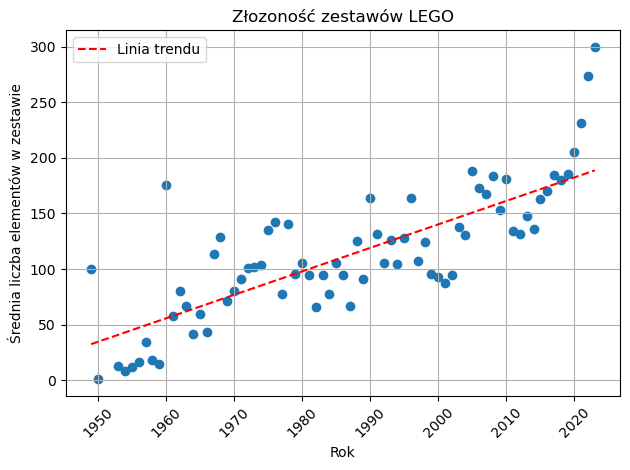

In [85]:
# Complexity trend in LEGO sets per year
# Group the data by year and calculate the average number of parts per set
parts_per_set = sets.groupby('year')['num_parts'].mean()

# Create a scatter plot of the data
plt.scatter(parts_per_set.index[:-1], parts_per_set.values[:-1])

# Calculate the slope and intercept of the best fit line
slope, intercept, r_value, p_value, std_err = stats.linregress(parts_per_set.index[:-2], parts_per_set.values[:-2])

# Calculate the x and y values for the best fit line
x = np.array(parts_per_set.index[:-1])
y = intercept + slope * x

# Plot the best fit line
plt.plot(x, y, 'r--', label='Linia trendu')

# Add a legend to the plot
plt.legend(loc='upper left')

# Show the plot
plt.title('Złozoność zestawów LEGO')
plt.xlabel('Rok')
plt.ylabel('Średnia liczba elementów w zestawie')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [86]:
#biggest sets ever per number of parts
sets_themes.sort_values("num_parts", ascending=False).head()

,set_num,name_sets,year,theme_id,num_parts,name_themes
4400,31203-1,World Map,2021,709,11695,LEGO Art
410,10307-1,Eiffel Tower,2022,721,10001,Icons
21063,BIGBOX-1,The Ultimate Battle for Chima,2015,571,9987,Legends of Chima
396,10294-1,Titanic,2021,721,9092,Icons
377,10276-1,Colosseum,2020,721,9036,Icons


In [87]:
#filer database
sets_themes = sets_themes.sort_values(by='year')
sets_themes = sets_themes[(sets_themes['year'] >= 1990) & (sets_themes['year'] <= 2023)]
sets_themes = sets_themes[(sets_themes['num_parts'] >= 25)]

#22 most popular themes
themes_to_keep = [252, 610, 52, 621, 22, 608, 579, 494, 246, 721, 603, 576, 577, 155, 693, 435, 601, 158, 684, 596, 690, 453]
sets_themes = sets_themes[sets_themes['theme_id'].isin(themes_to_keep)]

#reset index (number rows ascending)
sets_themes = sets_themes.reset_index(drop=True)

In [88]:
#getting prices from Brickeconomy.com
#save as csv
sets_themes.to_csv('brickeconomy.csv', index=False)
brickeconomy = pd.read_csv('brickeconomy.csv')

#prepare csv for brickeconomy format
brickeconomy = brickeconomy.drop(['name_sets','year','theme_id','num_parts','name_themes'], axis='columns')
brickeconomy['quantity']=1
brickeconomy.to_csv('brickeconomy.csv', index=False)

#read downloaded csv with prices and merge with dataframe
prices = pd.read_csv('prices.csv', sep=";")
df = pd.merge(sets_themes, prices, how='left', left_on='set_num', right_on='Number')
df = df.drop(['Number', 'Name'], axis='columns')

In [89]:
#filter out rows where any value is missing
df = df.dropna()

#change datatypes
df = df.astype({'Retail': float, 'Value': float})

#filter out rows where Retail is 0
df = df[(df['Retail'] != 0)]

#filter out sets not currently retired
df['Retired'] = df['Retired_date'].str[6:].astype(int)
df = df[(df['Retired'] <= 2023)]
df = df.drop(['Retired'], axis=1)

#reset index
df = df.reset_index(drop=True)
df

,set_num,name_sets,year,theme_id,num_parts,name_themes,Released_date,Retired_date,Retail,Value
0,5110-2,"Cross Axles, Nuts",1990,453,26,Technic,01.01.1996,01.01.1998,9.46,14.95
1,5233-2,Small Beams and Plates with holes,1993,453,26,Technic,01.01.1980,01.01.1982,3.07,14.04
2,5275-1,Toggle Joints and Connectors,1993,453,48,Technic,01.01.1993,01.01.1995,2.86,4.35
3,5286-1,Toggle Joints & Connectors,1994,453,64,Technic,01.01.1994,01.01.1996,3.95,7.62
4,5278-1,TECHNIC Chainlinks,1994,453,35,Technic,01.01.1994,01.01.1996,3.51,11.48
...,...,...,...,...,...,...,...,...,...,...
1960,60398-1,Family House and Electric Car,2023,52,462,City,01.06.2023,01.12.2023,52.99,60.11
1961,60371-1,Emergency Vehicles HQ,2023,52,706,City,01.01.2023,19.11.2023,64.99,62.68
1962,40658-1,Millennium Falcon Holiday Diorama,2023,158,282,Star Wars,01.10.2023,31.12.2023,29.99,28.67
1963,40624-1,Alex,2023,610,86,Brickheadz,01.04.2023,25.11.2023,9.99,14.44


In [90]:
#create new columns (HPR, HPY, APR)
df["HPR"] = round(((df["Value"] / df["Retail"])), 4)
df["HPY"] = round((df["HPR"]-1), 4)
df["APR"] = round((df["HPR"] **(1/(2024 - df["year"]))), 4)

df

,set_num,name_sets,year,theme_id,num_parts,name_themes,Released_date,Retired_date,Retail,Value,HPR,HPY,APR
0,5110-2,"Cross Axles, Nuts",1990,453,26,Technic,01.01.1996,01.01.1998,9.46,14.95,1.5803,0.5803,1.0136
1,5233-2,Small Beams and Plates with holes,1993,453,26,Technic,01.01.1980,01.01.1982,3.07,14.04,4.5733,3.5733,1.0503
2,5275-1,Toggle Joints and Connectors,1993,453,48,Technic,01.01.1993,01.01.1995,2.86,4.35,1.5210,0.5210,1.0136
3,5286-1,Toggle Joints & Connectors,1994,453,64,Technic,01.01.1994,01.01.1996,3.95,7.62,1.9291,0.9291,1.0221
4,5278-1,TECHNIC Chainlinks,1994,453,35,Technic,01.01.1994,01.01.1996,3.51,11.48,3.2707,2.2707,1.0403
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1960,60398-1,Family House and Electric Car,2023,52,462,City,01.06.2023,01.12.2023,52.99,60.11,1.1344,0.1344,1.1344
1961,60371-1,Emergency Vehicles HQ,2023,52,706,City,01.01.2023,19.11.2023,64.99,62.68,0.9645,-0.0355,0.9645
1962,40658-1,Millennium Falcon Holiday Diorama,2023,158,282,Star Wars,01.10.2023,31.12.2023,29.99,28.67,0.9560,-0.0440,0.9560
1963,40624-1,Alex,2023,610,86,Brickheadz,01.04.2023,25.11.2023,9.99,14.44,1.4454,0.4454,1.4454


In [91]:
#average APR per year
APR_yearly = df.groupby("year").mean('APR')
print(APR_yearly['APR'])

year
1990    1.013600
1993    1.031950
1994    1.031200
1995    1.074600
1996    1.019400
1997    1.002900
1998    1.024800
1999    1.082792
2000    1.106693
2001    1.091182
2002    1.097438
2003    1.084410
2004    1.094312
2005    1.119233
2006    1.085376
2007    1.104800
2008    1.134664
2009    1.103531
2010    1.070445
2011    1.098860
2012    1.090994
2013    1.086722
2014    1.092291
2015    1.090490
2016    1.088835
2017    1.104118
2018    1.104216
2019    1.084519
2020    1.060058
2021    1.030957
2022    1.049791
2023    1.251700
Name: APR, dtype: float64


In [92]:
df['APR'].mean()

1.0838647328244273

In [93]:
#highest APR values
df.sort_values("APR", ascending=False).head(10)

,set_num,name_sets,year,theme_id,num_parts,name_themes,Released_date,Retired_date,Retail,Value,HPR,HPY,APR
1939,30651-1,Quidditch Practice,2023,246,55,Harry Potter,01.03.2023,10.09.2023,3.39,7.41,2.1858,1.1858,2.1858
1940,30650-1,Kai and Rapton's Temple Battle,2023,435,47,Ninjago,02.06.2023,29.06.2023,3.99,8.00,2.0050,1.0050,2.0050
1938,30654-1,X-Wing Starfighter,2023,158,87,Star Wars,01.01.2023,01.06.2023,3.99,7.86,1.9699,0.9699,1.9699
1941,30642-1,Birthday Train,2023,22,58,Creator,01.01.2023,01.07.2023,3.99,7.25,1.8170,0.8170,1.8170
1942,30649-1,Ice Dragon Creature,2023,435,70,Ninjago,01.01.2023,01.05.2023,3.99,7.22,1.8095,0.8095,1.8095
1367,41636-1,Benny,2019,610,103,Brickheadz,01.02.2019,19.02.2019,8.79,132.13,15.0319,14.0319,1.7195
1309,77901-1,Sith Trooper Bust,2019,158,484,Star Wars,18.07.2019,21.07.2019,39.60,525.24,13.2636,12.2636,1.6770
1220,75188-2,Resistance Bomber (Finch Dallow version),2018,158,780,Star Wars,01.05.2019,27.07.2019,109.99,1759.41,15.9961,14.9961,1.5873
1886,71402-2,Mechakoopa,2022,690,30,Super Mario,01.01.2022,01.03.2023,3.99,9.79,2.4536,1.4536,1.5664
1851,30432-1,The Turtle Beach,2022,577,46,Minecraft,01.04.2022,01.04.2023,3.99,9.58,2.4010,1.4010,1.5495


In [94]:
#lowest APR values
df.sort_values("APR", ascending=True).head(10)

,set_num,name_sets,year,theme_id,num_parts,name_themes,Released_date,Retired_date,Retail,Value,HPR,HPY,APR
1958,40600-1,Disney 100 Years Celebration,2023,608,226,Disney,01.07.2023,09.07.2023,39.99,26.39,0.6599,-0.3401,0.6599
1956,41732-1,Downtown Flower and Design Stores,2023,494,2010,Friends,01.01.2023,25.11.2023,159.99,113.70,0.7107,-0.2893,0.7107
1872,71406-1,Yoshi's Gift House Expansion Set,2022,690,246,Super Mario,01.08.2022,01.12.2023,34.99,22.87,0.6536,-0.3464,0.8085
1924,76911-1,Aston Martin DB5,2022,601,298,Speed Champions,26.07.2022,31.12.2023,24.99,17.57,0.7031,-0.2969,0.8385
1936,76403-1,The Ministry of Magic,2022,246,990,Harry Potter,19.06.2022,20.12.2023,99.99,70.95,0.7096,-0.2904,0.8424
1815,10497-1,Galaxy Explorer,2022,721,1254,Icons,01.08.2022,01.12.2023,99.99,71.46,0.7147,-0.2853,0.8454
1864,75323-1,The Justifier,2022,158,1023,Star Wars,26.07.2022,25.11.2023,169.99,121.78,0.7164,-0.2836,0.8464
1848,21337-1,Table Football,2022,576,2339,LEGO Ideas and CUUSOO,01.11.2022,01.12.2023,249.99,179.77,0.7191,-0.2809,0.8480
1873,71405-1,Fuzzy Flippers Expansion Set,2022,690,154,Super Mario,01.08.2022,01.06.2023,24.99,18.21,0.7287,-0.2713,0.8536
1925,76831-1,Zurg Battle,2022,608,261,Disney,24.04.2022,31.12.2023,34.99,26.36,0.7534,-0.2466,0.8680


[*********************100%%**********************]  4 of 4 completed


Ticker,BTC-USD,Gold,DAX,SP500
Date,,,,
2023-08-31,25931.472656,1938.199951,15947.080078,4507.660156
2023-09-30,26967.916016,1848.099976,15386.580078,4288.049805
2023-10-31,34667.781250,1985.199951,14810.339844,4193.799805
2023-11-30,37712.746094,2038.099976,16215.429688,4567.799805
2023-12-31,42156.902344,2062.399902,16751.640625,4769.830078


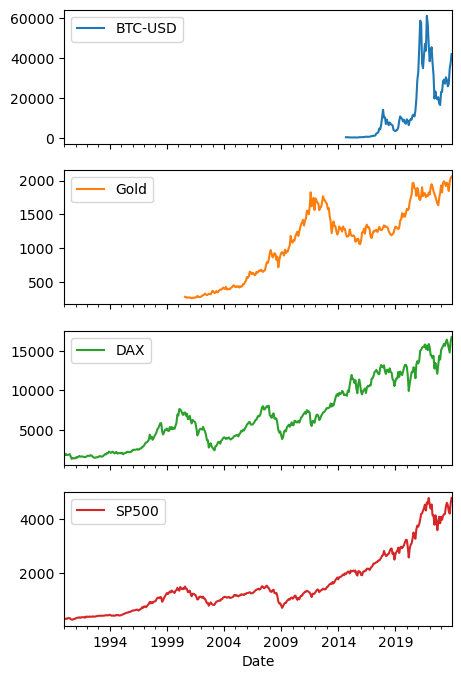

In [95]:
yf.pdr_override()
other_instruments = pdr.get_data_yahoo(["GC=F", "^GSPC", "^GDAXI", "BTC-USD"], start="1990-01-01", end="2023-12-31")
other_instruments = other_instruments.resample('M').last()
other_instruments = other_instruments['Close']
other_instruments= other_instruments.rename(columns={'GC=F': 'Gold', '^GSPC': 'SP500', 'WIG20.WA': 'WIG20', '^GDAXI': 'DAX'})
other_instruments = other_instruments.reset_index()

#Set 'Date' as index
other_instruments.set_index("Date", inplace=True)
other_instruments.plot(figsize=(5,8), subplots=True)

other_instruments.tail()

In [96]:
HPR_SP500 = round(((other_instruments['SP500'].iloc[-1] / other_instruments['SP500'].iloc[0])), 4)
HPY_SP500 = round((HPR_SP500-1), 4)
APR_SP500 = round((HPR_SP500 ** (1/34)), 4)

HPR_DAX = round(((other_instruments['DAX'].iloc[-1] / other_instruments['DAX'].iloc[0])), 4)
HPY_DAX = round((HPR_DAX-1), 4)
APR_DAX = round((HPR_DAX ** (1/34)), 4)

HPR_Gold = round(((other_instruments['Gold'].iloc[-1] / other_instruments['Gold'].iloc[132])), 4)
HPY_Gold = round((HPR_Gold-1), 4)
APR_Gold = round((HPR_Gold ** (1/23)), 4)

HPR_BTC = round(((other_instruments['BTC-USD'].iloc[-1] / other_instruments['BTC-USD'].iloc[300])), 4)
HPY_BTC = round((HPR_BTC-1), 4)
APR_BTC = round((HPR_BTC ** (1/9)), 4)

In [97]:
print(APR_SP500)
print(APR_DAX)
print(APR_Gold)
print(APR_BTC)

1.0818
1.0674
1.0932
1.7954
